In [1]:
# pre-generate the data so we can load it into something like JAXNS

# imports

In [2]:
# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [3]:
from cycler import cycler
import numpy as np
from scrinet.interfaces import lalutils
import lal
import lalsimulation as lalsim
import utils 
import glob
import os


 # ignore some scipy warnings with quad
import warnings
warnings.filterwarnings('ignore')

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

# load nr data

In [4]:
# get data
nrfiles_single_res = dict(
    q1="/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5",
    q2="/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5",
    q4="/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5",
    q5="/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5",
    q10="/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5",
    q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
)

In [5]:
def make_nr_dict():
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    root_dir = "/Users/spx8sk/work/data/"
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [6]:
nrfiles = make_nr_dict() 

In [7]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [8]:
nrstrain_q1_res2 = utils.NRStrain(nrfiles["q1"]["Res2"], 2, 2, 1000, -3000, 100)
nrstrain_q1_res3 = utils.NRStrain(nrfiles["q1"]["Res3"], 2, 2, 1000, -3000, 100)
nrstrain_q1_res4 = utils.NRStrain(nrfiles["q1"]["Res4"], 2, 2, 1000, -3000, 100)

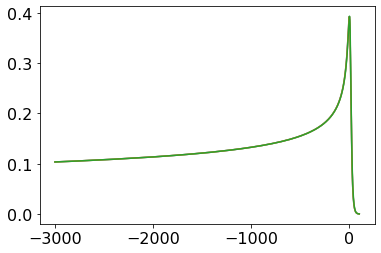

In [9]:
plt.figure()
plt.plot(nrstrain_q1_res2.times, nrstrain_q1_res2.amp)
plt.plot(nrstrain_q1_res3.times, nrstrain_q1_res3.amp)
plt.plot(nrstrain_q1_res4.times, nrstrain_q1_res4.amp)
# plt.xlim(-100,100)

In [10]:
params = lalutils.gen_td_wf_params(
    m1=20, m2=20, approximant=lalsim.SEOBNRv4PHM, f_min=12
)

In [11]:
times, amp, phase = lalutils.gen_td_wf(params, t_min=-2000, t_max=100) 

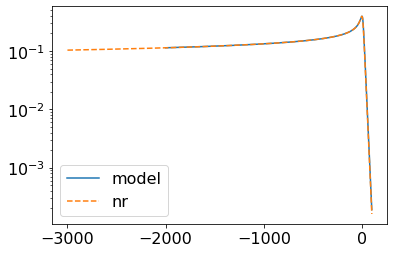

In [12]:
plt.figure()
plt.plot(
    times,
    amp
    / lalutils.td_amp_scale(40, 1)
    / lal.SpinWeightedSphericalHarmonic(0, 0, -2, 2, 2).real,
    label="model",
)
plt.plot(nrstrain_q1_res2.times, nrstrain_q1_res2.amp, ls="--", label="nr")
plt.legend()
plt.yscale("log")
# plt.xlim(-100,100)

# generate data

In [13]:
nrfiles

{'q1': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/spx8sk/work/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/spx8sk/work/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/spx8sk/work/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5'}}

In [16]:
wf_NR = {
    "Res3":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res3"]),
    "Res4":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res4"]),
    "Res5":utils.WaveformGeneration(nrfile=nrfiles["q10"]["Res5"])
}

wf_model = {
    "SEOBNRv4":utils.WaveformGeneration(approximant=lalsim.SEOBNRv4, q=10),
    "IMRPhenomB":utils.WaveformGeneration(approximant=lalsim.IMRPhenomB, q=10),
    "IMRPhenomC":utils.WaveformGeneration(approximant=lalsim.IMRPhenomC, q=10),
    "IMRPhenomD":utils.WaveformGeneration(approximant=lalsim.IMRPhenomD, q=10)
}

In [17]:
wf_NR["Res3"].q

10.0

In [18]:
import pickle
def save_waveform_pickle(obj, name):
    pickle.dump( obj, open( f"{name}", "wb" ) )
    
def load_waveform_pickle(name):
    return pickle.load( open( f"{name}", "rb" ) )

In [19]:
# !mkdir data

In [20]:
approxs = {"SEOBNRv4":lalsim.SEOBNRv4, "IMRPhenomB":lalsim.IMRPhenomB, "IMRPhenomC":lalsim.IMRPhenomC, "IMRPhenomD":lalsim.IMRPhenomD}

for nrcase in nrfiles:
    print(nrcase)
    resolutions = nrfiles[nrcase].keys()
    for res in resolutions:
        print("\t", res)
        
        wf_nr = utils.WaveformGeneration(nrfile=nrfiles[nrcase][res])
        
        name = f"data/{nrcase}_{res}.p"
        save_waveform_pickle(wf_nr, name)
        
    q = wf_nr.q
        
    for approx in approxs.keys():
        print("\t", approx)
        
        wf_model = utils.WaveformGeneration(approximant=approxs[approx], q=q)
        
        name = f"data/{nrcase}_{approx}.p"
        save_waveform_pickle(wf_model, name)

In [24]:
extra_q = [18]
for q in extra_q:

    for approx in approxs.keys():
        print("\t", approx)

        wf_model = utils.WaveformGeneration(approximant=approxs[approx], q=q)

        name = f"data/q{q}_{approx}.p"
        save_waveform_pickle(wf_model, name)

	 SEOBNRv4
	 IMRPhenomB
	 IMRPhenomC
	 IMRPhenomD


In [25]:
!ls data

q10_IMRPhenomB.p q18_SEOBNRv4.p   q2_IMRPhenomD.p  q4_SEOBNRv4.p
q10_IMRPhenomC.p q1_IMRPhenomB.p  q2_Res3.p        q5_IMRPhenomB.p
q10_IMRPhenomD.p q1_IMRPhenomC.p  q2_Res4.p        q5_IMRPhenomC.p
q10_Res3.p       q1_IMRPhenomD.p  q2_Res5.p        q5_IMRPhenomD.p
q10_Res4.p       q1_Res2.p        q2_SEOBNRv4.p    q5_Res3.p
q10_Res5.p       q1_Res3.p        q4_IMRPhenomB.p  q5_Res4.p
q10_SEOBNRv4.p   q1_Res4.p        q4_IMRPhenomC.p  q5_Res5.p
q18_IMRPhenomB.p q1_SEOBNRv4.p    q4_IMRPhenomD.p  q5_SEOBNRv4.p
q18_IMRPhenomC.p q2_IMRPhenomB.p  q4_Res3.p
q18_IMRPhenomD.p q2_IMRPhenomC.p  q4_Res5.p


In [ ]:
test_q5_Res3 = load_waveform_pickle("data/q5_Res3.p")